In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd
import re as regex
import tensorflow as tf
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove-embeddings/glove.6B.200d.txt
/kaggle/input/glove-embeddings/glove.6B.50d.txt
/kaggle/input/glove-embeddings/glove.6B.300d.txt
/kaggle/input/glove-embeddings/glove.6B.100d.txt


In [2]:
base_dir = '/kaggle/input/nlp-getting-started/'
#Load training and validation datasets
train_val_df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
test_df = pd.read_csv(os.path.join(base_dir, 'test.csv'))

In [3]:
#class distribution of train_val_data
train_val_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [4]:
#Extract train_val_sentences and its labels
train_val_sentences, train_val_labels = list(train_val_df['text']), list(train_val_df['target'])
#number of train_val examples
len(train_val_sentences), len(train_val_labels)

(7613, 7613)

In [5]:
#Length of test_df
print(f"Length of test_df: {len(test_df['id'])} sentences.")
#Test sentences
test_sentences = list(test_df['text'])

Length of test_df: 3263 sentences.


In [6]:
#Save all the global varibales in G class (Global)
@dataclass
class G:
    BATCH_SIZE = 32
    #75% of the train_val data used for training and rest 25% for validations
    TRAIN_SIZE = 0.65 
    EPOCHS = 20 
    #at least size of training
    EMBEDDING_DIM = 100
    TRUNCATING = 'post'
    PADDING = 'post'
    OOV_TOKEN = '<OOV>'
    MAXLEN = 20 
    
    CLASS_LABELS = {1: "Disaster",
                    0 :"Normal"}

In [7]:
#Convert train_val_sentences and test_sentences into lower case
train_val_sentences_lowercase = [text.lower() for text in train_val_sentences]
test_sentences_lowercase = [text.lower() for text in test_sentences]

In [8]:
#Sample sentences from train_val_sentences and test_sentences
train_val_sentences_lowercase[0], test_sentences_lowercase[0]

('our deeds are the reason of this #earthquake may allah forgive us all',
 'just happened a terrible car crash')

In [9]:
def remove_stopwords(text):
    """
    Remove stopwords from each sentence
    Args:
        sentence (string) : a row of sentence from a list
    
    Returns:
        sentence without stopwords
    """
    word_list = text.split(" ")
    return " ".join([word for word in word_list if word not in stopwords.words('english')])

In [10]:
def clean_text(text):
    """
        Take lower-cased text and remove links, domain names, and #, and 
        any small letters and numbers both separated by white space.
    """
    text = regex.sub('http:\S+', '', text)
    text = regex.sub('@\S+', '', text)
    text = regex.sub('#', '', text)
    text = regex.sub('[^a-z0-9\s]', '', text)
    return remove_stopwords(text)

In [11]:
#Remove clean and remove stopwords from train and val sentences
train_val_cleaned_sentences_without_stopwords = list(map(clean_text, train_val_sentences_lowercase))
test_cleaned_sentences_without_stopwords = list(map(clean_text, test_sentences_lowercase))

In [12]:
#Sample sentences after clean_text operation
print(train_val_cleaned_sentences_without_stopwords[0], test_cleaned_sentences_without_stopwords[0])
print(len(train_val_cleaned_sentences_without_stopwords), len(test_cleaned_sentences_without_stopwords)) 

deeds reason earthquake may allah forgive us happened terrible car crash
7613 3263


In [13]:
#lists containing count of the number of words in each rows of train_val and test
train_val_sentences_count = np.array([len(sentence) for sentence in train_val_cleaned_sentences_without_stopwords])
test_sentences_count = np.array([len(sentence) for sentence in test_cleaned_sentences_without_stopwords])

In [14]:
print("The number of empty text in 'train_val_cleaned_sentences_without_stopwords':",\
      sum(train_val_sentences_count == 0))
print("The number of empty text in 'test_cleaned_sentences_without_stopwords':",\
      sum(test_sentences_count == 0))
print(f"'train_val_cleaned_sentences_without_stopwords' max-length text: \
    {max(train_val_sentences_count)} and min-length sentence: {min(train_val_sentences_count)}")
print(f"'test_cleaned_sentences_without_stopwords' max-length text: \
    {max(test_sentences_count)} and min-length sentence: {min(test_sentences_count)}")

The number of empty text in 'train_val_cleaned_sentences_without_stopwords': 0
The number of empty text in 'test_cleaned_sentences_without_stopwords': 1
'train_val_cleaned_sentences_without_stopwords' max-length text:     140 and min-length sentence: 3
'test_cleaned_sentences_without_stopwords' max-length text:     129 and min-length sentence: 0


In [15]:
def split_data(sentences, labels, train_size):
    """ 
    convert train_val_cleaned_sentences_without_stopwords
    into train and validation data with the specified train_size parameter
    """
    return train_test_split(sentences, labels, train_size=train_size, random_state=42)

In [16]:
train_sentences_final, val_sentences_final, train_labels, val_labels = \
split_data(train_val_cleaned_sentences_without_stopwords, train_val_labels, G.TRAIN_SIZE)

In [17]:
#number of training and validation examples
print(f"Train examples: {len(train_sentences_final)}")
print(f"Validation examples: {len(val_sentences_final)}")
print(f'All in type :{type(train_sentences_final)}')

Train examples: 4948
Validation examples: 2665
All in type :<class 'list'>


In [18]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiate the tokenizer class with the given training sentences
    
    Args:
        train_sentences (list of string) : lower-cased sentences without stop words to be used for training
        oov_token (string) : symbole for out of vocabulary words
    
    Returns:
        tokenizer (object) : an instance of the Tokenizer class containing index-word dictionary
    """
    #instantiate the tokenizer object 
    tokenizer = Tokenizer(oov_token=oov_token)
    #fit the tokenizer with training sentences
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [19]:
tokenizer = fit_tokenizer(train_sentences_final, G.OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<oov> included in the vocabulary" if '<OOV>' in word_index else "<OOV> not included in the vocabulary")

Vocabulary contains 12242 words

<oov> included in the vocabulary


In [20]:
def seq_pad_and_truncate(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generate an array of sequences based on the tokenizer and pad them
    
    Args:
        sentences (list of string): sentences to be converted to token sequences and pad
        tokenizer (object): an instance of tokenizer object fitted on training sentences
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): the maximum length of each sequences
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded and truncate to the same length
    """
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)
    return pad_trunc_sequences

In [21]:
#pad and truncate validation, training dataset and convert their labels into numpy
train_pad_trunc_seq = seq_pad_and_truncate(train_sentences_final, tokenizer,\
                                           G.PADDING, G.TRUNCATING, G.MAXLEN)
val_pad_trunc_seq = seq_pad_and_truncate(val_sentences_final, tokenizer,\
                                         G.PADDING, G.TRUNCATING, G.MAXLEN)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [22]:
#pad and truncate testing dataset
test_pad_trunc_seq = seq_pad_and_truncate(test_cleaned_sentences_without_stopwords, tokenizer,\
                                           G.PADDING, G.TRUNCATING, G.MAXLEN)

In [23]:
# Define path to file containing the embeddings
GLOVE_FILE = '/kaggle/input/glove-embeddings/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [24]:
# Initialize an empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, G.EMBEDDING_DIM))

# Iterate all of the words in the vocabulary and if the vector representation for 
# each word exists within GloVe's representations, save it in the EMBEDDINGS_MATRIX array
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

In [25]:
def create_uncompiled_model():
    """
    Creates binary sentiment classifier
    
    Args:
        vocab_size (int): size of vocabulary
        embedding_dim (int): dimension of the embedding vector
        maxlen (int): length of input sequences
        embedding_matrix (array): represenation of words
    
    Returns:
        model (tf.keras.Model): sentiment classifier model
    """
    model = keras.Sequential([
        #usig pre-trained embeddings
        keras.layers.Embedding(VOCAB_SIZE+1, G.EMBEDDING_DIM, input_length=G.MAXLEN, weights=[EMBEDDINGS_MATRIX]),
        keras.layers.Bidirectional(keras.layers.LSTM(16, dropout=0.1, recurrent_dropout=0.1,\
                                                     kernel_regularizer='l1',activity_regularizer='l1')),
        keras.layers.Dense(16, activation='relu', kernel_regularizer='l1'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [26]:
def adujst_learnig_rate_model():
    """
    Model to pick the best learning rate for these dataset
    """
    model = create_uncompiled_model()
    lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    history = model.fit(train_pad_trunc_seq, train_labels, batch_size=G.BATCH_SIZE, epochs=50, callbacks=[lr_schedule])
    return history

In [27]:
lr_history = adujst_learnig_rate_model()

Epoch 1/50
155/155 [==============================] - 10s 27ms/step - loss: 13.8833 - accuracy: 0.5241 - lr: 1.0000e-06
Epoch 2/50
155/155 [==============================] - 4s 27ms/step - loss: 13.8616 - accuracy: 0.5257 - lr: 1.1220e-06
Epoch 3/50
155/155 [==============================] - 4s 27ms/step - loss: 13.8376 - accuracy: 0.5271 - lr: 1.2589e-06
Epoch 4/50
155/155 [==============================] - 4s 27ms/step - loss: 13.8099 - accuracy: 0.5275 - lr: 1.4125e-06
Epoch 5/50
155/155 [==============================] - 4s 28ms/step - loss: 13.7786 - accuracy: 0.5366 - lr: 1.5849e-06
Epoch 6/50
155/155 [==============================] - 4s 28ms/step - loss: 13.7445 - accuracy: 0.5390 - lr: 1.7783e-06
Epoch 7/50
155/155 [==============================] - 4s 29ms/step - loss: 13.7057 - accuracy: 0.5408 - lr: 1.9953e-06
Epoch 8/50
155/155 [==============================] - 4s 28ms/step - loss: 13.6624 - accuracy: 0.5402 - lr: 2.2387e-06
Epoch 9/50
155/155 [===========================

(1e-06, 0.001, 0.0, 14.0)

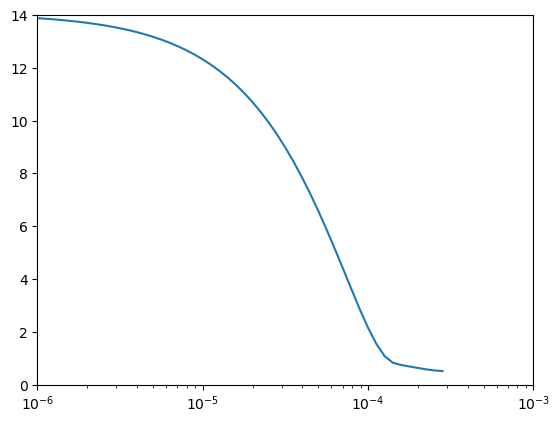

In [28]:
#Plot learning rate vs loss
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.axis(plt.axis([1e-6, 1e-3, 0, 14]))

In [29]:
#learning rate = 1e-3 based on the above graph
def create_model():
    model = create_uncompiled_model()
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=3e-4),
                  metrics=['accuracy'])
    return model

In [30]:
model = create_model()
history = model.fit(x=train_pad_trunc_seq, y=train_labels,\
                    validation_data=(val_pad_trunc_seq, val_labels),
                    batch_size=G.BATCH_SIZE, epochs=G.EPOCHS, shuffle=True)

Epoch 1/20
155/155 [==============================] - 13s 47ms/step - loss: 11.0560 - accuracy: 0.5241 - val_loss: 8.4350 - val_accuracy: 0.5947
Epoch 2/20
155/155 [==============================] - 7s 44ms/step - loss: 6.3466 - accuracy: 0.5847 - val_loss: 4.4573 - val_accuracy: 0.6105
Epoch 3/20
155/155 [==============================] - 7s 43ms/step - loss: 3.0852 - accuracy: 0.6675 - val_loss: 1.9305 - val_accuracy: 0.7066
Epoch 4/20
155/155 [==============================] - 5s 33ms/step - loss: 1.2863 - accuracy: 0.7445 - val_loss: 0.8861 - val_accuracy: 0.7722
Epoch 5/20
155/155 [==============================] - 5s 32ms/step - loss: 0.8034 - accuracy: 0.7823 - val_loss: 0.7534 - val_accuracy: 0.7846
Epoch 6/20
155/155 [==============================] - 5s 33ms/step - loss: 0.6964 - accuracy: 0.8054 - val_loss: 0.6724 - val_accuracy: 0.7835
Epoch 7/20
155/155 [==============================] - 5s 34ms/step - loss: 0.6203 - accuracy: 0.8219 - val_loss: 0.6217 - val_accuracy: 0.79

In [31]:
#ploting function 
def plot_results(epochs, train, val, message):
    plt.plot(epochs, train, 'r')
    plt.plot(epochs, val, 'b')
    plt.xlabel('Epochs')
    plt.ylabel(f"{message}")
    plt.legend([f"Train {message}", f"Validation {message}"])
    plt.show()

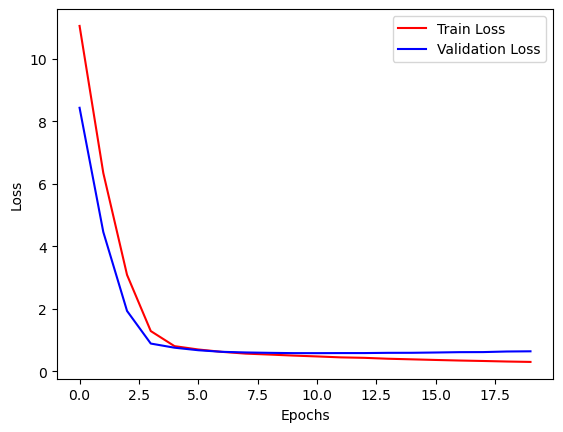

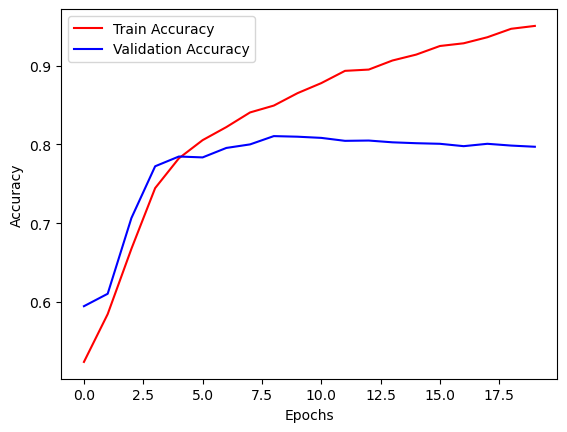

In [32]:
#Plot loss and accuracy over the specidied epochs
epochs = [*range(20)]
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_results(epochs, loss, val_loss, "Loss")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
plot_results(epochs, acc, val_acc, "Accuracy")

***
- the training example is 4948, which is very small and the result makes sense!
- the validation examples:2665 
- training accuracy : about 96%
- validation accuracy : about 80% 
- it was working good but there is still overfitting. 
- The model suffers from overfitting and i tried to add regularizers and dropouts.
- So the next avenue should be collecting more data that would denfinitely help the performance.
***

In [33]:
def predict(model, test_pad_trunc_seq, batch_size):
    predictions = []
    prediction_probas = model.predict(test_pad_trunc_seq, batch_size=batch_size).squeeze()
    for prediction_proba in prediction_probas:
        if prediction_proba > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [34]:
# lets assume that ''/kaggle/input/nlp-getting-started/sample_submission.csv' is the test label 
test_labels_df = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))
test_labels = np.array(test_labels_df['target'])

In [35]:
test_labels.shape

(3263,)

In [36]:
#Despite the val(test) set is uniclass (i.e the data contains only 0 class)
predictions = predict(model, test_pad_trunc_seq, G.BATCH_SIZE)
print("The model has predicted {} correctly out of {} examples".format(sum(predictions == test_labels), len(test_labels)))

102/102 [==============================] - 1s 5ms/step
The model has predicted 1979 correctly out of 3263 examples


In [37]:
#number of incorrectly predicted tweets
len(test_pad_trunc_seq[predictions!=test_labels])

1284

In [38]:
incorect_prediction_index = np.arange(0, len(predictions))[predictions != test_labels]

In [39]:
#sample incorrect predictions 
sample_index = 0
print(f"tweet: {tokenizer.sequences_to_texts(val_pad_trunc_seq)[incorect_prediction_index[sample_index]]}")
print(f"predicted label: {G.CLASS_LABELS[predictions[incorect_prediction_index[sample_index]]]} tweet.")
print(f"Actual label: {G.CLASS_LABELS[test_labels[incorect_prediction_index[sample_index]]]} tweet.")

print('\n\n')

sample_index = 100
print(f"tweet: {tokenizer.sequences_to_texts(val_pad_trunc_seq)[sample_index]}")
print(f"predicted label: {G.CLASS_LABELS[predictions[sample_index]]} tweet.")
print(f"Actual label: {G.CLASS_LABELS[test_labels[sample_index]]} tweet.")

tweet: new weapon cause <OOV> destruction <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
predicted label: Disaster tweet.
Actual label: Normal tweet.



tweet: sitting still <OOV> traffic like sitting war zone dont move police dont care <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
predicted label: Normal tweet.
Actual label: Normal tweet.


**As you see in the above first example in the above the sample_submission file has problem with labeling or my assumption was wrong!!!**

****Conclusion**:

The performance interms of accuracy is pretty good but can be improved with by collecting more training examples. Hence, the model suffered from overfitting and I have applied l1 regularizations and dropouts to reduce the impact of overfitting. I suggest more training examples than dealing more on ways to avoid overfitting beside data collection.

results:
>     - Training Accuracy: 96% 
>     - Validation Accuracy: about 80%

Data problem:
>     * Either the sample_submission is not the label for testing data or there must be problems while labeling the target.**